# Data Boycott and Data Strikes: Simulated Campaign Results

## Goals of this notebook
This notebook includes code for exploring the results of simulated boycotts. It also generates plots (for papers/presentations). This notebook covers 3 broad categories of experiments

1. MovieLens 1M random boycotts
2. MovieLens 1M homogeneous boycotts (e.g. fans of Comedy movies boycott together, people of a single age group boycott together)
3. MovieLens 20M random boycotts



In [1]:
from collections import defaultdict, OrderedDict
import json
from pprint import pprint

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
sns.set_color_codes("dark")

from scipy import stats
from scipy.interpolate import interp1d

# http://files.grouplens.org/datasets/movielens/ml-20m-README.txt

num_users = {
    'ml-20m': 138493,
    'ml-1m': 6040
}
num_ratings = {
    'ml-20m': 20000263,
    'ml-1m': 1000209
}
for dataset in ['ml-20m', 'ml-1m']:
    ratio = num_ratings[dataset] / num_users[dataset]
    print(dataset, ratio)

ml-20m 144.4135299257002
ml-1m 165.5975165562914


First things first: let's load our master data files. Each is a single csv that was created by the `process_all.py` script.

In [2]:
df_1m = pd.read_csv('ml-1m_collected_10_28/all_results.csv', dtype={'indices': str})
df_1m = df_1m[df_1m.ratingfrac.notna()]
df_1m['dataset'] = 'ml-1m'

In [149]:
df_20m = pd.read_csv('ml-20m_collected_11_01/all_results.csv', dtype={'indices': str})
df_20m = df_20m[df_20m.ratingfrac.notna()]
df_20m['dataset'] = 'ml-20m'

Now we apply transformation that will affect the entire dataframe.
1. Calculate the number of users included in each experiment.
2. Calculate the number of ratings missing per experiment (so we can estimate how much we'd "expect" performance to decrease)
3. Calculate the number of ratings missing per experiment, rounded to the nearest 10^5

In [286]:

for df, dataset in [
    (df_1m, 'ml-1m',),
    (df_20m, 'ml-20m',),
]:
    # Whoops! Assign doesn't work in a for loop.
#     df = df.assign(num_users_boycotting = [(NUM_USERS - int(x))/NUM_USERS for x in df.num_users])
#     df = df.assign(num_ratings_missing = [NUM_RATINGS - int(x) for x in df.num_ratings])
#     df = df.assign(nrm_rounded = [round(x, -5) for x in df.num_ratings_missing])
    filename_ratingcv_standards = 'standard_results/{}_ratingcv_standards_for_{}.json'.format(
        dataset, 'GlobalMean')
    with open(filename_ratingcv_standards, 'r') as f:
        global_mean_res = json.load(f)
        
    filename_ratingcv_standards = 'standard_results/{}_ratingcv_standards_for_{}.json'.format(
        dataset, 'SVD')
    with open(filename_ratingcv_standards, 'r') as f:
        svd_res = json.load(f)
    
    df['num_users_boycotting'] = [(num_users[dataset] - int(x)) / num_users[dataset] for x in df.num_users]
    df['num_ratings_missing'] = [num_ratings[dataset] - int(x) for x in df.num_ratings]
    df['nrm_rounded'] = [round(x, -5) for x in df.num_ratings_missing]
    try:
        for group in ['all', 'non-boycott']:
            #BAD: hard-coded constant, why?!?!?
#             df['loghits_' + group] = [np.log10(-1*(x - 89045.6)) for x in df['totalhits_' + group]]
#             df['standards_loghits_' + group] = [np.log10(-1 * (x - 89045.6)) for x in df['standards_totalhits_' + group]]
            #BAD: hard-coded constant, why?!?!?
            denom = (svd_res['hits'] / svd_res['normhits'] * num_users[dataset])
            print(svd_res['hits'], num_users[dataset], denom)
        
            df['biznormhits_' + group] = [x / denom for x in df['totalhits_' + group]]
            df['normhits_' + 'biz' + group] = [x / denom for x in df['totalhits_' + group]]
            df['hitsbeyondrand_' + group] = [x - global_mean_res['totalhits'] for x in df['totalhits_' + group]]
    except KeyError as err:
        print('Skipping')
        print(err)
    

    # drop columns we're not going to use.
    drops = [
        #'tail',
        # 'vanilla',
    ]
    for column in df.columns.values:
        for drop in drops:
            if drop in column:
                df = df.drop(column, axis=1)

14.75632421589539 6040 117370.03696488823
14.75632421589539 6040 117370.03696488823
10.901500402382888 138493 2068444.9883455127
10.901500402382888 138493 2068444.9883455127


# EDIT ME
Define all the lists that can be used throughout. By editing this cell we can easily modify the full notebook.

In [287]:
id_vars = ['name','algo_name', 'indices', 'ratingfrac', 'userfrac', 'num_ratings', 'num_users', 'num_users_boycotting']
#id_vars = [x for x in id_vars if x in list(df.columns.values)]
metrics = [
    'rmse',
    'ndcg10',
    #'tailndcg10',
    #'ndcg5',
    #'tailndcg5',
    #'ndcgfull',
    #'tailndcgfull',
    #'ndcgfull',
    'prec10t4',
    #'tailprec10t4',
    #'prec5t4',
    #'tailprec5t4',
    'hits',
    'totalhits',
    'normhits',
]

organized_experiments = [
    'gender', 'state', 'power', 'genre', 'occupation', 'age'
]
algo_names = [
    #'KNNBaseline_item_msd',
    'SVD'
]
standard_algo_names = [
    'SVD', 
    'GlobalMean', 
    'GuessThree',
    'MovieMean', 
    'KNNBaseline_item_msd',
    'KNNBasic_user_msd',
    'KNNBasic_item_msd',
]

# Flags
A variety of flags to turn various analyses on or off. Turning more flags off will make the notebook run faster.

In [288]:
flags = {}

## Load and Organize Standard Results
For any of our visualizations to be meaningful, we need standard results to compare the boycott results to. These standards let us evaluate "what is the effect of the boycott compared to other algorithms".

In particular, we compare the boycott performance to performance when using very non-personalized algorithms (MovieMean) and simpler personalized algorithms (user-based KNN, item-based KNN).

Below, we load these results from json files into Python data structures so we can use below when generating plots.

In [289]:
dataset_to_algo_to_metric_to_altalgo = {}
ds2standards = {}

one_mill_svd = {}
for dataset in [
    'ml-1m',
    'ml-20m',
]:
    standard_results = {}
    algo2metric2altalgo = defaultdict(lambda: defaultdict(dict))

    for algo_name in standard_algo_names:
        try:
            filename_ratingcv_standards = 'standard_results/{}_ratingcv_standards_for_{}.json'.format(
                dataset, algo_name)
            with open(filename_ratingcv_standards, 'r') as f:
                standard_results[algo_name] = json.load(f)
                if algo_name == 'SVD' and dataset == 'ml-1m':
                    one_mill_svd = standard_results[algo_name]
        except FileNotFoundError:
            print('File not found: {}'.format(filename_ratingcv_standards))
    for main_algo_name in algo_names:
        for metric in metrics:
            goodval = standard_results[main_algo_name].get(metric, 0)
            for st_algo_name in standard_algo_names:
                val = standard_results.get(st_algo_name, {}).get(metric)
                if val:
                    algo2metric2altalgo[main_algo_name][metric][st_algo_name] = (val - goodval) / goodval * 100 if goodval else 0
                else:
                    algo2metric2altalgo[main_algo_name][metric][st_algo_name] = 0
            if dataset == 'ml-20m':
                val = one_mill_svd.get(metric)
                if val:
                    algo2metric2altalgo[main_algo_name][metric]['1M_SVD'] = (val - goodval) / goodval * 100 if goodval else 0
                else:
                    algo2metric2altalgo[main_algo_name][metric]['1M_SVD'] = 0
            
    dataset_to_algo_to_metric_to_altalgo[dataset] = algo2metric2altalgo
    ds2standards[dataset] = standard_results
pprint(dataset_to_algo_to_metric_to_altalgo)

File not found: standard_results/ml-20m_ratingcv_standards_for_KNNBasic_user_msd.json
{'ml-1m': defaultdict(<function <lambda> at 0x00000187429C7F28>,
                      {'SVD': defaultdict(<class 'dict'>,
                                          {'hits': {'GlobalMean': -17.84257427465695,
                                                    'GuessThree': -17.84257427465695,
                                                    'KNNBaseline_item_msd': 0,
                                                    'KNNBasic_item_msd': 0,
                                                    'KNNBasic_user_msd': 0,
                                                    'MovieMean': -1.8152304579426788,
                                                    'SVD': 0.0},
                                           'ndcg10': {'GlobalMean': -25.473630285204873,
                                                      'GuessThree': -25.473630285204873,
                                                      'KNNB

# Estimate change in "hits" based on precision or ndcg

For a given list of k-items, we assume users will click the items in that list that are "good" (rating over 4).


One way to do this is to follow this linear model:

* a user who gets a list with "full precision" (i.e. SVD w/ full data) provides 5 hits
* a user who gets a list with "un-personalized precision" (i.e. MovieMean) provides 5/ratio hits!
* note that in this case even users w/ bad lists still provide hits

Using these two points, we fit a line:


When ratio=1, recommender adds NO VALUE and therefore strikes do NO DAMAGE!

Anchor:hits

In [290]:
normalize_hits = False

for df, dataset in [
    (df_1m, 'ml-1m',),
    (df_20m, 'ml-20m',),
]:
    metric2altalgo = dataset_to_algo_to_metric_to_altalgo[dataset]['SVD']
    # will only work for SVD as its written right now.
    
    #personalization_boost_coefficient
    for pbc in [
        1.1, 1.02, 2, 4, 8,
    ]:
        for old_metric, k in [
            ('prec10t4', 10),
            #('ndcg10', 10),
            # the actual count of 4 star ratings in the whole ds
            ('hits', 1),
            ('totalhits', 1),
            ('normhits', 1)
        ]:
            for group in ['non-boycott', 'all']:
                # name the new dataframe column
                new_metric = '{}boosthits-{}'.format(pbc, old_metric)
                total_possible_hits = num_users[dataset] * k
                if old_metric == 'totalhits':
                    total_possible_hits = ds2standards[dataset]['SVD'][old_metric]
                elif old_metric == 'hits':
                    total_possible_hits = ds2standards[dataset]['SVD'][old_metric] * num_users[dataset]
                
                # boycotting users provide 0 hits. 
                # so with a full boycott, damage = total possible hits
                comparison = -1 * total_possible_hits
                #comparison = -1 * ds2standards[dataset]['SVD'][old_metric] * total_possible_hits

                key_template = 'percent_increase_{}_{}'
                new_key = key_template.format(new_metric, group)

   
                # no missing users in a strike ("All Users" perspective)
                if group == 'all':
                    frac_miss_arr = [0] * len(df.index)
                # there are missing users in a data boycott!
                else:
                    frac_miss_arr = list(df['num_users_boycotting'])

                labor_metric = 'labor-' + new_metric
                consumer_metric = 'consumer-' + new_metric

                # get the predicted diff if we switched to MovieMean
                pred_diff = metric2altalgo[old_metric]['MovieMean']
                # should get more negative as prec_val gets more negative
                print(pred_diff)
                coefficients = np.polyfit(
                    [pred_diff, 0], # x values
                    [total_possible_hits/pbc - total_possible_hits, 0],# y values
                    1, # polynomial order, i.e. this is a line
                )

                df[key_template.format(labor_metric, group)] = [
                    ( coefficients[1] + coefficients[0] * prec_val  * (1 - frac_miss)) for (
                        prec_val, frac_miss
                    ) in zip(df[key_template.format(old_metric, group)], frac_miss_arr)
                ]
                df[key_template.format(consumer_metric, group)] = [
                    (comparison * frac_miss) for frac_miss in frac_miss_arr
                ]

                df[new_key] = [
                    (labor_power + consumer_power) for (
                        labor_power, consumer_power
                    ) in zip(
                        df[key_template.format('labor-' + new_metric, group)],
                        df[key_template.format('consumer-' + new_metric, group)],
                    )
                ]
                df[new_key.replace('percent_increase_', '')] = [
                    (labor_power + consumer_power + ds2standards[dataset]['SVD']['totalhits']) for (
                        labor_power, consumer_power
                    ) in zip(
                        df[key_template.format('labor-' + new_metric, group)],
                        df[key_template.format('consumer-' + new_metric, group)],
                    )
                ]

                if normalize_hits:
                    print('Normalizing. Will divide hit values by total possible hits.')
                    df[new_key] /= total_possible_hits
                    df[key_template.format(labor_metric, group)] /= total_possible_hits
                    df[key_template.format(consumer_metric, group)] /= total_possible_hits

                for st_al_nm in standard_algo_names:
                    old_val = metric2altalgo[old_metric][st_al_nm]
                    # convert from percent to raw precision change
                    old_val *= ds2standards[dataset]['SVD'][old_metric] / 100
                    # multiply by k and the probability of clicks b/c we want to get from prec@5 to hits
                    if not normalize_hits:
                        old_val *= total_possible_hits
                    metric2altalgo[new_metric][st_al_nm] = old_val
                    metric2altalgo[labor_metric][st_al_nm] = old_val
                    metric2altalgo[consumer_metric][st_al_nm] = old_val
            df['increase_hit-ratio@{}_non-boycott'.format(k)] = [
                boycott_val / strike_val for (boycott_val, strike_val) in zip(
                    df[key_template.format(new_metric, 'non-boycott')], df[key_template.format(new_metric, 'all')])
            ]
            df['increase_hit-ratio@{}_all'.format(k)] = [
                boycott_val / strike_val for (boycott_val, strike_val) in zip(
                    df[key_template.format(new_metric, 'non-boycott')], df[key_template.format(new_metric, 'all')])
            ]
            #print(df[['num_users_boycotting', 'increase_hits-prec5t4_non-boycott', 'increase_hits-prec5t4_all', 'increase_hit-ratio@5_non-boycott']])


-2.3220059942464455
-2.3220059942464455
-1.8152304579426788
-1.8152304579426788
-1.8152497147529003
-1.8152497147529003
-1.5798117185527312
-1.5798117185527312
-2.3220059942464455
-2.3220059942464455
-1.8152304579426788
-1.8152304579426788
-1.8152497147529003
-1.8152497147529003
-1.5798117185527312
-1.5798117185527312
-2.3220059942464455
-2.3220059942464455
-1.8152304579426788
-1.8152304579426788
-1.8152497147529003
-1.8152497147529003
-1.5798117185527312
-1.5798117185527312
-2.3220059942464455
-2.3220059942464455
-1.8152304579426788
-1.8152304579426788
-1.8152497147529003
-1.8152497147529003
-1.5798117185527312
-1.5798117185527312
-2.3220059942464455
-2.3220059942464455
-1.8152304579426788
-1.8152304579426788
-1.8152497147529003
-1.8152497147529003
-1.5798117185527312
-1.5798117185527312
-5.237244453762422
-5.237244453762422
-4.4336790028117266
-4.4336790028117266
-4.433677915599779
-4.433677915599779
-4.227782317836208
-4.227782317836208
-5.237244453762422
-5.237244453762422
-4.43367

# Compare Precision-Estimated Hits to Actual Hits


   num_users_boycotting    variable     value
0              0.799997  ndcg10_all  0.771670
1              0.799997  ndcg10_all  0.771311
2              0.799997  ndcg10_all  0.771399
3              0.799997  ndcg10_all  0.771010
4              0.799997  ndcg10_all  0.771828


C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


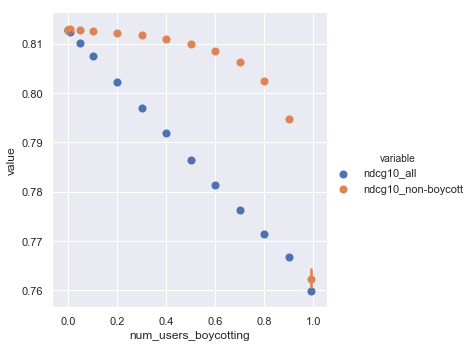

In [291]:
hits_df = df_20m.copy()
hits_df = hits_df[~hits_df.hits_all.isna()]
hits_metric = 'ndcg10'
metric2 = '1.02boosthits-hits'
include = [
    'num_users_boycotting', 
]
hits_cols = [
    '{}_all'.format(hits_metric), 
    '{}_non-boycott'.format(hits_metric),
    #'{}_boycott'.format(hits_metric),
]
# for col in hits_cols:
#     hits_df[col] *= 0.76 / 14.75#num_users['ml-1m']

plot_metric2 = False
include += hits_cols
if plot_metric2:
    cols = [
        '{}_all'.format(metric2), 
        '{}_non-boycott'.format(metric2),
    ]

    include += cols
    
hits_df = hits_df[include].melt(id_vars='num_users_boycotting')
print(hits_df.head())

# for k in hits_df.num_users_boycotting:
#     print(k)
#     matches_from_hits = hits_df[hits_df.num_users_boycotting == k]
#     matches_from_orig = samples_df_1m[hits_df.num_users_boycotting == k]

sns.lmplot(
        x="num_users_boycotting", y="value", hue='variable', data=hits_df,
        fit_reg=False,
        x_estimator=np.mean, ci=99, 
    )
plt.show()

In [292]:
from collections import defaultdict
name2vals = defaultdict(list)

for name, group in hits_df.groupby('num_users_boycotting'):
    #print(name)
    for subname, subgroup in group.groupby('variable'):
        #print(subname, subgroup['value'].mean())
        name2vals[subname].append(subgroup['value'].mean())
        
print(name2vals)

defaultdict(<class 'list'>, {'ndcg10_all': [0.8129081074873608, 0.8128423533168279, 0.8128282685171198, 0.8125423636617057, 0.8124273375430325, 0.8101695736425064, 0.8075213122382463, 0.8022295462636322, 0.7970403581039163, 0.7918459368722981, 0.7865190814747399, 0.7814013341786267, 0.7763348055439019, 0.7714346972044385, 0.7667029193784956, 0.7599577210570352], 'ndcg10_non-boycott': [0.8129131820056309, 0.81286586325835, 0.8128755441310009, 0.812792296973695, 0.8129294496933346, 0.8127419591202626, 0.8125824312789611, 0.8121679127513408, 0.8117315810033595, 0.8110525931020078, 0.8100519492372562, 0.8085384617090006, 0.8062784926147506, 0.802533158518172, 0.7948171954372831, 0.7623742641012967]})


In [293]:
from scipy.stats import pearsonr

try:
    for group in [
        'all', 'non-boycott',
    ]:
        x = '{}_{}'.format(hits_metric,group)
        y = '{}_{}'.format(metric2, group)
        print(x, y)
        print(pearsonr(name2vals[x], name2vals[y]))
        plt.plot(name2vals[x], name2vals[y])
    plt.show()
except Exception as err:
    print(err)
    pass

ndcg10_all 1.02boosthits-hits_all
operands could not be broadcast together with shapes (16,) (0,) 


C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:3006: RuntimeWarning: Mean of empty slice.
  my = y.mean()
C:\Users\Nick\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Seperate out our data
We want to separate the simuated boycotts into homogenous vs. heterogenous boycotts.

In [294]:
samples_df_20m = df_20m[df_20m['type'] == 'sample_users']
print('\n===Heterogenous 20M Boycotts===\n')
print(samples_df_20m.name.value_counts())
samples_df_1m = df_1m[df_1m['type'] == 'sample_users']
print('\n===Heterogenous Boycotts===\n')
print(samples_df_1m.name.value_counts())
org_df = df_1m[df_1m['type'].isin(organized_experiments)]
print('\n===Homogenous Boycotts===\n')
print(org_df.name.value_counts())


===Heterogenous 20M Boycotts===

69 user sample        30
138 user sample       30
14 user sample        30
6925 user sample      20
55397 user sample     20
124644 user sample    20
41548 user sample     20
692 user sample       20
13849 user sample     20
69246 user sample     20
83096 user sample     20
137108 user sample    20
96945 user sample     20
110794 user sample    20
1385 user sample      20
27699 user sample     10
Name: name, dtype: int64

===Heterogenous Boycotts===

302 user sample     250
1208 user sample    250
1 user sample       250
5980 user sample    250
6 user sample       250
3624 user sample    250
60 user sample      250
604 user sample     250
30 user sample      250
1812 user sample    250
3 user sample       250
4832 user sample    250
4228 user sample    250
3020 user sample    250
2416 user sample    250
5436 user sample    250
Name: name, dtype: int64

===Homogenous Boycotts===

Series([], Name: name, dtype: int64)


In [295]:
# bonus
if False:
    metric = 'ndcgfull_non-boycott'
    print('1...')
    name = '1 user sample'
    print(samples_df_1m[(samples_df_1m.indices == '1-to-250') & (samples_df_1m.name == name)][metric].mean())
    print(samples_df_1m[(samples_df_1m.indices == '251-to-500') & (samples_df_1m.name == name)][metric].mean())
    print(samples_df_1m[(samples_df_1m.name == name)][metric].mean())
    print(samples_df_1m[(samples_df_1m.name == name)]['ndcg10_frac_non-boycott'].mean())

    print('3...')
    name = '3 user sample'
    print(samples_df_1m[(samples_df_1m.indices == '1-to-250') & (samples_df_1m.name == name)][metric].mean())
    print(samples_df_1m[(samples_df_1m.indices == '251-to-500') & (samples_df_1m.name == name)][metric].mean())
    print(samples_df_1m[(samples_df_1m.name == name)][metric].mean())
    print(samples_df_1m[(samples_df_1m.name == name)]['ndcg10_frac_non-boycott'].mean())

    print('6')
    name = '6 user sample'
    print(samples_df_1m[(samples_df_1m.indices == '1-to-250') & (samples_df_1m.name == name)][metric].mean())
    print(samples_df_1m[(samples_df_1m.indices == '251-to-500') & (samples_df_1m.name == name)][metric].mean())
    print(samples_df_1m[(samples_df_1m.name == name)][metric].mean())
    print(samples_df_1m[(samples_df_1m.name == name)]['ndcg10_frac_non-boycott'].mean())

    print('30')
    name = '30 user sample'
    print(samples_df_1m[(samples_df_1m.indices == '1-to-250') & (samples_df_1m.name == name)][metric].mean())
    print(samples_df_1m[(samples_df_1m.indices == '251-to-500') & (samples_df_1m.name == name)][metric].mean())
    print(samples_df_1m[(samples_df_1m.name == name)][metric].mean())
    print(samples_df_1m[(samples_df_1m.name == name)]['ndcg10_frac_non-boycott'].mean())

## Clean up the homogenous boycott "name" columns
This is helpful because our homogenous boycott plots are going to very cluttered. We want to remove as much text as possible without making the plots too confusing.

In [296]:
org_df.name = [
    x.replace('excluded', '')
    .replace('users from', '')
    .replace('using threshold 4', '')
    .replace('Top 10% contributors', 'power users')
    .strip()
    .lower()
    for x in list(org_df.name)
]
# can ignore the below warning, the code in this cell works

## Data Manipulating Helpers
In the following two cells, we define two functions (`select_cols` and `fill_in_longform`) that will help with general purpose manipulating of our result data.

In [297]:
def select_cols(cols, metrics, groups, increase=False, percents=False):
    """
    take a list of cols and filter based on metrics/groups/percents
    
    The returned columns must match all the metrics and groups passed
    if percents is True, return columns with "percent" in the name
    if percents is False return only columns without "percent" in the name
    
    returns a list of cols
    """
    if percents is True and increase is False:
        raise ValueError('Set increase=True to get percent increase')
    ret = []
    for col in cols:
        x = col.split('_')
        
        if percents:
            if 'percent' not in col:
                continue
        else:
            if 'percent' in col:
                continue
        if increase:
            if 'increase' not in col:
                continue
        else:
            if 'increase' in col:
                continue
        for group in groups:
            if 'standards' in group:
                if 'standards' not in col:
                    continue
                #print(group, x)
                group = group.replace('standards_', '')
            else:
                if 'standards' in col:
                    continue
            if group == x[-1]:
                for metric in metrics:
                    if metric == x[-2]:
                        ret.append(col)

    return ret

In [298]:
def fill_in_longform(df):
    """
    Fill in a longform dataframe with metric, group, and name information
    """
    df = df.assign(
        metric=[x.split('_')[-2] for x in df.increase_type]
    )
    df = df.assign(
        group=['standards_' + x.split('_')[-1] if 'standards' in x else x.split('_')[-1] for x in df.increase_type]
    )
    return df
    

In [302]:
metric2title = {
    'ndcg10': 'NDCG@10',
    '2hits-prec5t4': 'Loss in Precision@5-estimated hits, pb=2',
    '4hits-prec5t4': 'Loss in Precision@5-estimated hits, pb=4',
    '2hits-ndcg10': 'Loss in ndcg@10-estimated hits, pb=2',
    'labor-hits-prec5t4': 'Loss in hits from data labor power',
    'consumer-hits-prec5t4': 'Loss in hits from consumer power',
    'rmse': 'RMSE',
    'prec10t4': 'Precision',
    'totalhits': 'Total Hits',
    'loghits': 'Log-Transformed Hits',
    'normhits': 'Frac of Ideal Hits across Users',
    'biznormhits': 'Frac of Ideal Hits Total across System'
}

group2scenario = {
    'all': 'Data Strike, users',
    'non-boycott': 'Data Boycott, users',
    'bizall': 'Data Strike, system',
    'biznon-boycott': 'Data Boycott, system'
}

In [317]:
def p_b_curve(
        df, dataset, metrics, groups,
        increase=False, percents=False, normalize=True,
        reg_plot=False, hue='group', row='metric', col='algo_name',
        show_interp=False, legend=True,
        ylabel="", plot_horiz_lines=True, height=5,
        title_template='Recommender {} vs. Size of Boycott for {}',
        aspect=1, palette={'all': 'b', 'non-boycott': 'g', 'standards_non-boycott': 'y'},
        label_map = {
            'all': 'Data Strike',
            'non-boycott': 'Data Boycott',
            'bizall': 'Data Strike, system',
            'biznon-boycott': 'Data Boycott, system',
            'standards_non-boycott': 'Trad. Boycott',
        },
        line_names=['all'],
        ylim=None,
        print_vals = [0.1, 0.2, 0.3],
        hue_order=None,
    ):
    """
    Plots a performance vs. boycott size (P v B) curve
    
    Args:
        df - the dataframe to use for plotting the pb curve
        metrics - which metrics to plot the curve for.
        groups - which groups to include.
          for each metric, 
        percents - show the Y-axis in percent change or raw change. Set this True for percent change.
        normalize - should we normalize the y-axis relative to MovieMean (no personalization)
        reg_plot - ?
        hue - which facet to use to determine hue. default is group
          (each group will appear as a separate (distinctly colored) trajectory on each plot)
        row - which facet to use to split plots into different rows. default is metric.
        save - should we save a PNG file?
        show_interp - include the interpolated function on this plot?
        
    Returns:
        ?
    """
    algo2metric2altalgo = dataset_to_algo_to_metric_to_altalgo[dataset]
    
    algo_names = list(set(df.algo_name))
    df = df.copy()
    algo2metric2group2 = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

    increase_cols = select_cols(list(df.columns.values), metrics, groups, increase=increase, percents=percents)
    #print('increase_cols', increase_cols)
    if normalize:
        for metric in metrics:
            for algo_name in algo_names:
                movie_val = abs(algo2metric2altalgo[algo_name][
                    metric.replace('coverage-weighted-', '')
                ]['MovieMean'])           
                for increase_col in increase_cols:
                    if increase_col.split('_')[-2] == metric:
                        df.loc[df.algo_name == algo_name, increase_col] /= movie_val
    longform = df[increase_cols + id_vars].melt(
        id_vars = id_vars,
        var_name='increase_type'
    )
    longform = fill_in_longform(longform)

    print('metrics', metrics)
    print(row)
    grid = sns.lmplot(
        x="num_users_boycotting", y="value", hue=hue, data=longform,
        sharey='row', sharex='col',
        height=height, 
        aspect=aspect,
        row=row, col=col,
        fit_reg=False,
        x_estimator=np.mean, ci=99, 
        palette=palette,
        legend=legend,
        legend_out=True,
        hue_order=hue_order
    )

    algo_to_size_to_decreases = defaultdict(lambda: defaultdict(list))
    
    for metric in metrics:
        for algo_name in algo_names:
            filt = df[df.algo_name == algo_name]
            for group in groups:
                key = '{}_{}'.format(metric, group)
                if increase:
                    key = 'increase_' + key
                if percents:
                    key = 'percent_' + key
                # funky code to handle the fact that we want to treat "standards" as being a unique group
                if 'standards' in key:
                    key = 'standards_' + key.replace('standards_', '')
                x = filt.num_users_boycotting
                user_nums = sorted(list(set(filt.num_users_boycotting)))
                nrm_rounded = sorted(list(set(filt.nrm_rounded)))
                y = filt[key]

                num2mean = OrderedDict()
                roundnum2mean = OrderedDict()
                for num_users_boycotting in user_nums:
                    filt_by_name = filt[filt.num_users_boycotting == num_users_boycotting]
                    num2mean[num_users_boycotting] = np.mean(filt_by_name[key])
                    roundnum2mean[round(num_users_boycotting, 2)] = np.mean(filt_by_name[key])
                nrm_rounded_to_mean = OrderedDict()
                for num in nrm_rounded:
                    filt_by_nrm = filt[filt.nrm_rounded == num]
                    nrm_rounded_to_mean[num] = np.mean(filt_by_nrm[key])

                # for printing out values at various intervals
                if print_vals:
                    if group == 'non-boycott':
                        for num in print_vals:
                            val_nb = roundnum2mean.get(num)
                            if val_nb is None:
                                continue
                            val_all = np.mean(filt[filt.num_users_boycotting == num][key.replace('non-boycott', 'all')])
                            print(
                                'Algo:{}  |  Metric:{}  |  #users:{}'.format(
                                    algo_name, metric, num, 
                                )
                            )
                            print('NB Val:{}  |  ALL val:{}'.format(
                                val_nb,
                                val_all
                            ))
                            if percents is False:
                                try:
                                    ratio_nb = val_nb / algo2metric2altalgo[algo_name][metric]['MovieMean']
                                    ratio_all = val_all / algo2metric2altalgo[algo_name][metric]['MovieMean']

                                    print('ratio_nb: {}  |  ratio_all:{}'.format(
                                        ratio_nb,
                                        ratio_all,
                                    ))
                                except KeyError:
                                    print('Metric {} has no MovieMean comparison.'.format(metric))
                            algo_to_size_to_decreases[algo_name][num].append(val_nb)
                meany = np.array(list(num2mean.values()))
                meany_ratings = np.array(list(nrm_rounded_to_mean.values()))

                algo2metric2group2[algo_name][metric][group]['x'] = user_nums
                algo2metric2group2[algo_name][metric][group]['y'] = meany

                smoothf_ratings = interp1d(nrm_rounded, meany_ratings, kind='quadratic', bounds_error=False, fill_value='extrapolate')
                algo2metric2group2[algo_name][metric][group]['interp_ratings'] = smoothf_ratings
                algo2metric2group2[algo_name][metric][group]['max_user_units'] = max(user_nums)
                algo2metric2group2[algo_name][metric][group]['xnew_ratings'] = np.linspace(
                    min(filt.num_ratings_missing), max(filt.num_ratings_missing), num=1000)

    if plot_horiz_lines:        
        for x in grid.facet_data():
            i_row, i_col, i_hue = x[0]
            
            # this is bad hard-coding. Fix after deadline?
            if row == 'metric' and col == 'algo_name' and hue == 'group':
                metric = grid.row_names[i_row]
                algo_name = grid.col_names[i_col]
                group = grid.hue_names[i_hue]
            else:
                group = grid.col_names[i_col]
                _ = grid.row_names[i_row]
                metric = grid.hue_names[i_hue]

            lines_caption = ""

            # we should store all the horiztonal lines in one data structure
            lines = {}

            metric_key = metric.replace('coverage-weighted-', '').replace('biz', '')
            # needs to handle the coverage-weighted mtrics
            comparisons = algo2metric2altalgo[algo_name][metric_key]
            if increase is False:
                comparisons = ds2standards[dataset]
                comparisons = {
                    key: comparisons[key].get(metric_key, 0) for key in comparisons.keys()
                }
                
            if 'all' in line_names or 'MovieMean' in line_names:
                lines['MovieMean'] = {
                    'value': comparisons['MovieMean'],
                    'color': 'r',
                    'name': 'MovieMean',
                    'linestyle': '-'
                }
            if 'all' in line_names or 'Zero' in line_names:
                lines['Zero'] = {
                    'value': 0,
                    'color': '0.3',
                    'name': 'Zero',
                    'linestyle': '-'
                }
            if 'all' in line_names or 'MaxDamage' in line_names:
                lines['MaxDamage'] = {
                    'value': -114000,
                    'color': '0.3',
                    'name': 'MaxDamage',
                    'linestyle': '-'
                }
                
            if 'GlobalMean' in line_names:
                lines['GlobalMean'] = {
                    'value': comparisons['GlobalMean'],
                    'color': '0.3',
                    'name': 'GlobalMean',
                    'linestyle': '-'
                }
            if 'SVD' in line_names:
                lines['SVD'] = {
                    'value': comparisons['SVD'],
                    'color': '0.3',
                    'name': 'SVD',
                    'linestyle': '-'
                }
            if 'KNNBasic_item_msd' in line_names:
                lines['KNNBasic_item_msd'] = {
                    'value': comparisons['KNNBasic_item_msd'],
                    'color': 'r',
                    'name': 'Item KNN (1999)',
                    'linestyle': ':'
                }
            if 'KNNBaseline_item_msd' in line_names:
                lines['KNNBaseline_item_msd'] = {
                    'value': comparisons['KNNBaseline_item_msd'],
                    'color': 'y',
                    'name': 'Item KNN + Baselines: 2010',
                    'linestyle': ':',
                }
            if 'KNNBasic_user_msd' in line_names:
                lines['KNNBasic_user_msd'] = {
                    'value': comparisons['KNNBasic_user_msd'],
                    'color': 'c',
                    'name': 'User KNN (1994)',
                    'linestyle': ':'
                }
            if '1M_SVD' in line_names:
                lines['1M_SVD'] = {
                    'value': comparisons['1M_SVD'],
                    'color': '0.3',
                    'name': 'ml-1m SVD',
                    'linestyle': ':'
                }
            #print('lines', lines)

            if normalize:
                norm_val = abs(comparisons['MovieMean'])
                for key in lines.keys():
                    lines[key]['value'] /= norm_val

            ax = grid.axes[i_row, i_col]
            
            if ylim:
                ax.set(ylim=ylim)


            linestyle = '-' if group != 'all' else '--'
            ax.plot(
                algo2metric2group2[algo_name][metric][group]['x'],
                algo2metric2group2[algo_name][metric][group]['y'],
                linestyle=linestyle, color=grid._colors[i_hue]
            )
            if show_interp:
                xnew_ratings = algo2metric2group2[algo_name][metric][group]['xnew_ratings']
                ynew_ratings = algo2metric2group2[algo_name][metric][group]['interp_ratings'](xnew_ratings)
                ax.plot(
                    xnew_ratings * algo2metric2group2[algo_name][metric][group]['max_user_units'] / num_ratings[dataset],
                    ynew_ratings, '-')

            plt.setp(ax.get_xticklabels(), visible=True, rotation=45)
            
            try:
                metric4title = metric2title[metric]
                ax.set_title(
                    title_template.format(
                        metric4title, dataset.upper())
                )
            except:
                ax.set_title(
                    title_template.format(
                        group2scenario[group], dataset.upper())
                )
                pass
            for line in lines.values():
                ax.axhline(line['value'], color=line['color'], linestyle=line['linestyle'])
                #ax.text(0.7, line['value'] + 0.05, line['name'])
                lines_caption += "{} colored line (value of {}) shows comparison with {}\n".format(
                    line['color'], line['value'], line['name']
                )

    plt.subplots_adjust(hspace=0.2)
    if print_vals:
        algo_to_size_to_mean_dec = defaultdict(dict)
        for algo_name, size2dec in algo_to_size_to_decreases.items():
            for size, decs in size2dec.items():
                algo_to_size_to_mean_dec[algo_name][size] = np.mean(decs)
        print('=====\nSize to Mean Decrease')
        pprint(algo_to_size_to_mean_dec)
                   
    grid.set_xlabels('Fraction of users boycotting')
    grid.set_ylabels(ylabel)
    if label_map:
        if grid._legend:
            for t in grid._legend.texts:
                t.set_text(label_map[t.get_text()])
            grid._legend.set_title('')
    return algo2metric2group2

# Plot hits here

In [311]:
pinks = {}
pinks[2] = '#f8bbd0'
pinks[3] = '#f48fb1'
pinks[4] = '#f06292'
pinks[5] = '#ec407a'
pinks[6] = '#e91e63'
pinks[7] = '#d81b60'

purples = {}
purples[2] = '#e1bee7'
purples[3] = '#ce93d8'
purples[4] = '#ba68c8'
purples[5] = '#ab47bc'
purples[6] = '#9c27b0'
purples[7] = '#8e24aa'
#https://material.io/tools/color/#!/?view.left=0&view.right=0&primary.color=E1BEE7

### Look at totalhits

metrics ['1.02boosthits-totalhits', '1.1boosthits-totalhits', '2boosthits-totalhits', '4boosthits-totalhits', '8boosthits-totalhits', 'labor-1.02boosthits-totalhits', 'labor-1.1boosthits-totalhits', 'labor-2boosthits-totalhits', 'labor-4boosthits-totalhits', 'labor-8boosthits-totalhits', 'consumer-1.1boosthits-totalhits']
algo_name


C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


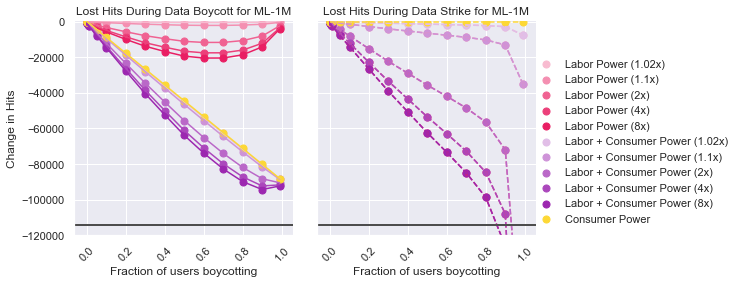

In [284]:
metric = 'totalhits'
_ = p_b_curve(
    samples_df_1m[samples_df_1m.algo_name == 'SVD'], 'ml-1m',
    show_interp=False,
    increase=True, percents=True, normalize=False,
    metrics=[
        '1.02boosthits-{}'.format(metric),
        '1.1boosthits-{}'.format(metric),
        '2boosthits-{}'.format(metric),
        '4boosthits-{}'.format(metric),
        '8boosthits-{}'.format(metric),
        
        'labor-1.02boosthits-{}'.format(metric),
        'labor-1.1boosthits-{}'.format(metric),
        'labor-2boosthits-{}'.format(metric),
        'labor-4boosthits-{}'.format(metric),
        'labor-8boosthits-{}'.format(metric),
        'consumer-1.1boosthits-{}'.format(metric),  
    ],
    groups=['all', 'non-boycott'],
    #hue='metric', col='group', row='algo_name',
    hue='metric', col='group', row='algo_name',
    
    legend=True, 
    ylabel='Change in Hits',
    title_template='Lost Hits During {} for {}',
    height=4, aspect=1,
    label_map={
        'labor-1.02boosthits-{}'.format(metric): 'Labor Power (1.02x)', 
        'labor-1.1boosthits-{}'.format(metric): 'Labor Power (1.1x)', 
        'labor-2boosthits-{}'.format(metric):  'Labor Power (2x)', 
        'labor-4boosthits-{}'.format(metric): 'Labor Power (4x)',
        'labor-8boosthits-{}'.format(metric): 'Labor Power (8x)',

        '1.02boosthits-{}'.format(metric): 'Labor + Consumer Power (1.02x)', 
        '1.1boosthits-{}'.format(metric): 'Labor + Consumer Power (1.1x)', 
        '2boosthits-{}'.format(metric): 'Labor + Consumer Power (2x)', 
        '4boosthits-{}'.format(metric): 'Labor + Consumer Power (4x)',
        '8boosthits-{}'.format(metric): 'Labor + Consumer Power (8x)',

        'consumer-1.1boosthits-{}'.format(metric): 'Consumer Power',
    },
    hue_order = [
        'labor-1.02boosthits-{}'.format(metric), 
        'labor-1.1boosthits-{}'.format(metric) ,
        'labor-2boosthits-{}'.format(metric), 
        'labor-4boosthits-{}'.format(metric),
        'labor-8boosthits-{}'.format(metric),

        '1.02boosthits-{}'.format(metric), 
        '1.1boosthits-{}'.format(metric), 
        '2boosthits-{}'.format(metric), 
        '4boosthits-{}'.format(metric),
        '8boosthits-{}'.format(metric),
        'consumer-1.1boosthits-{}'.format(metric),
    ],
    palette={
        'labor-1.02boosthits-{}'.format(metric): pinks[2], 
        'labor-1.1boosthits-{}'.format(metric): pinks[3], 
        'labor-2boosthits-{}'.format(metric):  pinks[4], 
        'labor-4boosthits-{}'.format(metric): pinks[5],
        'labor-8boosthits-{}'.format(metric): pinks[6],
        
        '1.02boosthits-{}'.format(metric): purples[2], 
        '1.1boosthits-{}'.format(metric): purples[3], 
        '2boosthits-{}'.format(metric):  purples[4], 
        '4boosthits-{}'.format(metric): purples[5],
        '8boosthits-{}'.format(metric): purples[6],
        
        'consumer-1.1boosthits-{}'.format(metric): '#fdd835',
    },
    plot_horiz_lines=True,
    line_names=['MaxDamage',], ylim=(-120000, 500),
    print_vals=None
)
#plt.ylim(-114000, 200)
plt.savefig('ml-1m_totalhits.png', bbox_inches='tight', dpi=300)
plt.show()

metrics ['1.02boosthits-totalhits', '1.1boosthits-totalhits', '2boosthits-totalhits', '4boosthits-totalhits', '8boosthits-totalhits', 'labor-1.02boosthits-totalhits', 'labor-1.1boosthits-totalhits', 'labor-2boosthits-totalhits', 'labor-4boosthits-totalhits', 'labor-8boosthits-totalhits', 'consumer-1.1boosthits-totalhits']
algo_name


C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


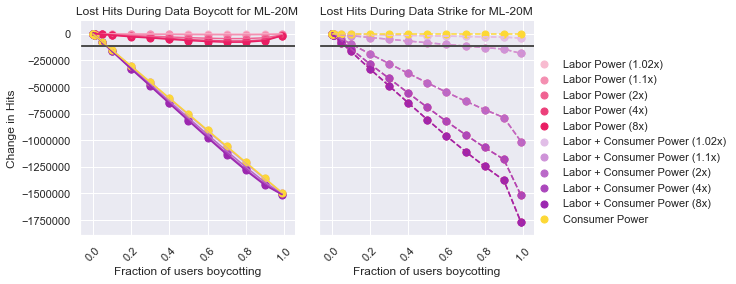

In [211]:
metric = 'totalhits'
df = samples_df_20m
ds = 'ml-20m'
_ = p_b_curve(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=True, percents=True, normalize=False,
    metrics=[
        '1.02boosthits-{}'.format(metric),
        '1.1boosthits-{}'.format(metric),
        '2boosthits-{}'.format(metric),
        '4boosthits-{}'.format(metric),
        '8boosthits-{}'.format(metric),
        
        'labor-1.02boosthits-{}'.format(metric),
        'labor-1.1boosthits-{}'.format(metric),
        'labor-2boosthits-{}'.format(metric),
        'labor-4boosthits-{}'.format(metric),
        'labor-8boosthits-{}'.format(metric),
        'consumer-1.1boosthits-{}'.format(metric),  
    ],
    groups=['all', 'non-boycott'],
    #hue='metric', col='group', row='algo_name',
    hue='metric', col='group', row='algo_name',
    
    legend=True, 
    ylabel='Change in Hits',
    title_template='Lost Hits During {} for {}',
    height=4, aspect=1,
    label_map={
        'labor-1.02boosthits-{}'.format(metric): 'Labor Power (1.02x)', 
        'labor-1.1boosthits-{}'.format(metric): 'Labor Power (1.1x)', 
        'labor-2boosthits-{}'.format(metric):  'Labor Power (2x)', 
        'labor-4boosthits-{}'.format(metric): 'Labor Power (4x)',
        'labor-8boosthits-{}'.format(metric): 'Labor Power (8x)',

        '1.02boosthits-{}'.format(metric): 'Labor + Consumer Power (1.02x)', 
        '1.1boosthits-{}'.format(metric): 'Labor + Consumer Power (1.1x)', 
        '2boosthits-{}'.format(metric): 'Labor + Consumer Power (2x)', 
        '4boosthits-{}'.format(metric): 'Labor + Consumer Power (4x)',
        '8boosthits-{}'.format(metric): 'Labor + Consumer Power (8x)',

        'consumer-1.1boosthits-{}'.format(metric): 'Consumer Power',
    },
    hue_order = [
        'labor-1.02boosthits-{}'.format(metric), 
        'labor-1.1boosthits-{}'.format(metric) ,
        'labor-2boosthits-{}'.format(metric), 
        'labor-4boosthits-{}'.format(metric),
        'labor-8boosthits-{}'.format(metric),

        '1.02boosthits-{}'.format(metric), 
        '1.1boosthits-{}'.format(metric), 
        '2boosthits-{}'.format(metric), 
        '4boosthits-{}'.format(metric),
        '8boosthits-{}'.format(metric),
        'consumer-1.1boosthits-{}'.format(metric),
    ],
    palette={
        'labor-1.02boosthits-{}'.format(metric): pinks[2], 
        'labor-1.1boosthits-{}'.format(metric): pinks[3], 
        'labor-2boosthits-{}'.format(metric):  pinks[4], 
        'labor-4boosthits-{}'.format(metric): pinks[5],
        'labor-8boosthits-{}'.format(metric): pinks[6],
        
        '1.02boosthits-{}'.format(metric): purples[2], 
        '1.1boosthits-{}'.format(metric): purples[3], 
        '2boosthits-{}'.format(metric):  purples[4], 
        '4boosthits-{}'.format(metric): purples[5],
        '8boosthits-{}'.format(metric): purples[6],
        
        'consumer-1.1boosthits-{}'.format(metric): '#fdd835',
    },
    plot_horiz_lines=True,
    line_names=['MaxDamage',], 
    #ylim=(-120000, 500),
    print_vals=None
)
#plt.ylim(-114000, 200)
plt.savefig('ml-1m_complicatedhits.svg', bbox_inches='tight', dpi=300)
plt.show()

metrics ['biznormhits']
metric


C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


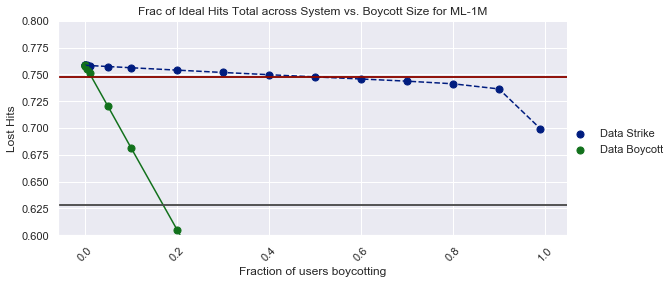

In [320]:
_ = p_b_curve(
    samples_df_1m[samples_df_1m.algo_name == 'SVD'], 'ml-1m',
    show_interp=False,
    increase=False, percents=False, normalize=False,
    metrics=[
        'biznormhits',
        #'normhits',
    ],
    groups=[
        'all', 'non-boycott', 
        #'standards_non-boycott'
    ],
    legend=True, 
    ylabel='Lost Hits',
    title_template='{} vs. Boycott Size for {}',
    height=4, aspect=2,
    line_names = ['MovieMean', 'GlobalMean'], #line_names=['SVD', 'MovieMean', 'GlobalMean'],
    print_vals=False,
    ylim=(0.6, 0.8)
)
#plt.savefig('ml-1m_totalhits.png', bbox_inches='tight', dpi=300)
plt.show()

metrics ['totalhits']
metric


C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Algo:SVD  |  Metric:totalhits  |  #users:0.1
NB Val:80003.5384  |  ALL val:88753.03999999998
ratio_nb: -44073.02078044421  |  ratio_all:-48893.01966483516
Algo:SVD  |  Metric:totalhits  |  #users:0.2
NB Val:71045.80640000004  |  ALL val:88491.65680000003
ratio_nb: -39138.31018542323  |  ratio_all:-48749.02669357857
Algo:SVD  |  Metric:totalhits  |  #users:0.3
NB Val:62034.81679999997  |  ALL val:88233.49919999996
ratio_nb: -34174.26059667191  |  ratio_all:-48606.81066792548
=====
Size to Mean Decrease
defaultdict(<class 'dict'>,
            {'SVD': {0.1: 80003.5384,
                     0.2: 71045.80640000004,
                     0.3: 62034.81679999997}})


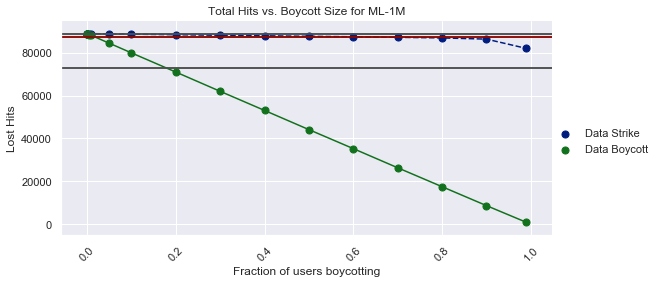

In [319]:
_ = p_b_curve(
    samples_df_1m[samples_df_1m.algo_name == 'SVD'], 'ml-1m',
    show_interp=False,
    increase=False, percents=False, normalize=False,
    metrics=[
        'totalhits',
        #'labor-1.02boosthits-totalhits'
    ],
    groups=[
        'all', 'non-boycott',
    ],
    legend=True, 
    ylabel='Lost Hits',
    title_template='{} vs. Boycott Size for {}',
    height=4, aspect=2,
    line_names=['SVD', 'MovieMean', 'GlobalMean'],
)
plt.show()

metrics ['4boosthits-hits', 'labor-4boosthits-hits', 'consumer-4boosthits-hits', '4boosthits-prec10t4', 'labor-4boosthits-prec10t4', 'consumer-4boosthits-prec10t4']
algo_name


C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Algo:SVD  |  Metric:4boosthits-hits  |  #users:0.1
NB Val:-14534.033883723578  |  ALL val:-12772.37589736535
Algo:SVD  |  Metric:4boosthits-hits  |  #users:0.2
NB Val:-26927.77262284819  |  ALL val:-23585.302355155218
Algo:SVD  |  Metric:4boosthits-hits  |  #users:0.3
NB Val:-39145.32145390891  |  ALL val:-34264.83857577088
Algo:SVD  |  Metric:labor-4boosthits-hits  |  #users:0.1
NB Val:-5621.214057322764  |  ALL val:-12772.37589736535
Algo:SVD  |  Metric:labor-4boosthits-hits  |  #users:0.2
NB Val:-9102.13297004657  |  ALL val:-23585.302355155218
Algo:SVD  |  Metric:labor-4boosthits-hits  |  #users:0.3
NB Val:-12406.861974706462  |  ALL val:-34264.83857577088
Algo:SVD  |  Metric:consumer-4boosthits-hits  |  #users:0.1
NB Val:-8912.819826400835  |  ALL val:0.0
Algo:SVD  |  Metric:consumer-4boosthits-hits  |  #users:0.2
NB Val:-17825.63965280167  |  ALL val:0.0
Algo:SVD  |  Metric:consumer-4boosthits-hits  |  #users:0.3
NB Val:-26738.459479202502  |  ALL val:0.0
Algo:SVD  |  Metric:4boo

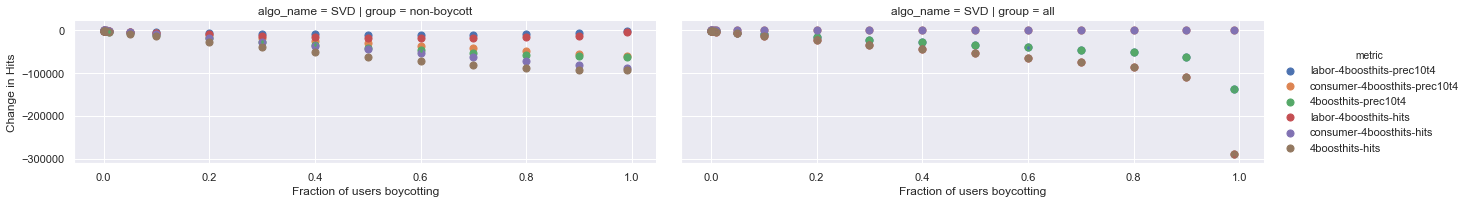

In [99]:
# Compare Hits and PRec10t4 Hits

_ = p_b_curve(
    samples_df_1m[samples_df_1m.algo_name == 'SVD'], 'ml-1m',
    show_interp=False,
    increase=True, percents=True, normalize=False,
    metrics=[
        '4boosthits-hits',
        'labor-4boosthits-hits',
        'consumer-4boosthits-hits',
        '4boosthits-prec10t4',
        'labor-4boosthits-prec10t4',
        'consumer-4boosthits-prec10t4',
    ],
    groups=['all', 'non-boycott'],
    hue='metric', col='group', row='algo_name',
    legend=True, 
    ylabel='Change in Hits',
    title_template='{} vs. Boycott Size for {}',
    height=3, aspect=3,
    label_map=None, palette=None, plot_horiz_lines=False,
)
plt.savefig('ml-1m_hits.svg', bbox_inches='tight', dpi=300)
plt.show()

metrics ['ndcg10']
metric


C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Algo:SVD  |  Metric:ndcg10  |  #users:0.1
NB Val:-0.07085964863871262  |  ALL val:-0.17130077661705964
Algo:SVD  |  Metric:ndcg10  |  #users:0.2
NB Val:-0.1449045497293481  |  ALL val:-0.331758996325422
Algo:SVD  |  Metric:ndcg10  |  #users:0.3
NB Val:-0.22944106247949025  |  ALL val:-0.4855720701239015
=====
Size to Mean Decrease
defaultdict(<class 'dict'>,
            {'SVD': {0.1: -0.07085964863871262,
                     0.2: -0.1449045497293481,
                     0.3: -0.22944106247949025}})


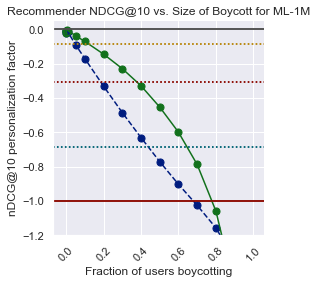

In [208]:
# Anchor: Paper Figure
# Figure 1 (Left)
_ = p_b_curve(
    samples_df_1m[samples_df_1m.algo_name == 'SVD'], 'ml-1m',
    show_interp=False,
    increase=True,percents=True, normalize=True,
    metrics=['ndcg10',],
    groups=['non-boycott', 'all', ],
    legend=False,
    ylabel='nDCG@10 personalization factor',
    height=4,
    line_names=['Zero', 'KNNBasic_item_msd', 'KNNBaseline_item_msd', 'KNNBasic_user_msd', 'MovieMean']
)
plt.ylim(-1.2, 0.05)
plt.savefig('ml-1m_ndcg_curve.png', bbox_inches='tight', dpi=300)
plt.show()

metrics ['ndcg10']
metric


C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Algo:SVD  |  Metric:ndcg10  |  #users:0.1
NB Val:-0.008421436564657676  |  ALL val:nan
Algo:SVD  |  Metric:ndcg10  |  #users:0.2
NB Val:-0.017171460153558755  |  ALL val:nan
Algo:SVD  |  Metric:ndcg10  |  #users:0.3
NB Val:-0.02640247146521187  |  ALL val:nan
=====
Size to Mean Decrease
defaultdict(<class 'dict'>,
            {'SVD': {0.1: -0.008421436564657676,
                     0.2: -0.017171460153558755,
                     0.3: -0.02640247146521187}})


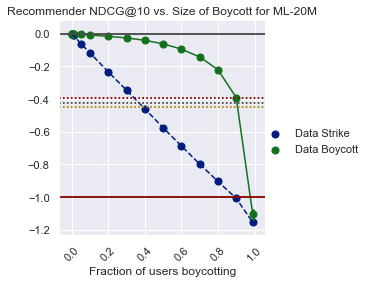

In [209]:
#Anchor: Paper Figure
# Figure 1 (Right)
twenty_algo_to_metric_to_group_to = p_b_curve(
    samples_df_20m, 'ml-20m',
    show_interp=False,
    increase=True, percents=True, normalize=True,
    metrics=['ndcg10'],
    groups=['non-boycott', 'all', ], 
    height=4, aspect=1,
    line_names=['Zero', 'KNNBasic_item_msd', 'KNNBaseline_item_msd', '1M_SVD', 'MovieMean']
)
#plt.ylim(-1.2, 0.05)
plt.savefig('ml-20_ndcg_curve.png', bbox_inches='tight', dpi=300)
plt.show()

# Bunch of Metrics for all Groups, don't save

['percent_increase_ndcg10_all', 'percent_increase_ndcg10_boycott', 'percent_increase_ndcg10_non-boycott', 'percent_increase_prec10t4_all', 'percent_increase_prec10t4_boycott', 'percent_increase_prec10t4_non-boycott', 'percent_increase_rmse_all', 'percent_increase_rmse_boycott', 'percent_increase_rmse_non-boycott']


C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


metrics ['ndcg10', 'prec10t4', 'rmse']
Algo:SVD  |  Metric:ndcg10  |  #users:0.1
NB Val:-0.07085964863871262  |  ALL val:-0.17130077661705964
Algo:SVD  |  Metric:ndcg10  |  #users:0.2
NB Val:-0.1449045497293481  |  ALL val:-0.331758996325422
Algo:SVD  |  Metric:ndcg10  |  #users:0.3
NB Val:-0.22944106247949025  |  ALL val:-0.4855720701239015
Algo:SVD  |  Metric:prec10t4  |  #users:0.1
NB Val:-0.1109143482802749  |  ALL val:-0.20024298871314042
Algo:SVD  |  Metric:prec10t4  |  #users:0.2
NB Val:-0.1715421557807308  |  ALL val:-0.3444955971295722
Algo:SVD  |  Metric:prec10t4  |  #users:0.3
NB Val:-0.2589716555292411  |  ALL val:-0.4924199775877206
Algo:SVD  |  Metric:rmse  |  #users:0.1
NB Val:0.02458575394385233  |  ALL val:0.1302116988192838
Algo:SVD  |  Metric:rmse  |  #users:0.2
NB Val:0.04972223302564479  |  ALL val:0.25543713244451477
Algo:SVD  |  Metric:rmse  |  #users:0.3
NB Val:0.07799221430277228  |  ALL val:0.3799621282084871
{'MovieMean': {'value': -2.594307467586317, 'color'

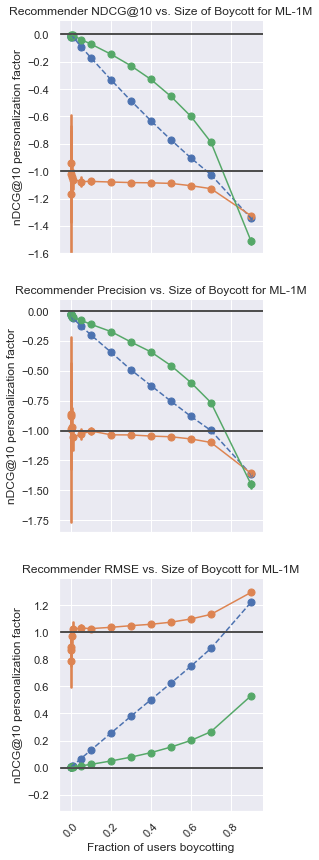

In [240]:
_ = p_b_curve(
    samples_df_1m[samples_df_1m.algo_name == 'SVD'], 'ml-1m',
    show_interp=False,
    percents=True, normalize=True,
    metrics=['ndcg10', 'prec10t4', 'rmse'],
    groups=['non-boycott', 'all', 'boycott'],
    legend=False,
    ylabel='nDCG@10 personalization factor',
    height=4,
    palette=None,
)
#plt.ylim(-1.2, 0.05)
plt.show()

In [ ]:
algo_to_metric_to_group_to = p_b_curve(
    samples_df_1m, 'ml-1m',
    metrics=metrics,
    percents=True, normalize=True, show_interp=True,
    groups=['non-boycott', 'all', ],
)
plt.show()

## Find intersection of the non-boycott curve with horizontal lines

In [ ]:
movie_val = -1 * dataset_to_algo_to_metric_to_altalgo['ml-1m']['SVD']['ndcg10']['MovieMean']
for group in ['all', 'non-boycott']:
    found_item, found_user = False, False
    found_itembasic = False
    for x in range(0, num_ratings['ml-1m'], int(num_ratings['ml-1m'] / 10000)):
        y = algo_to_metric_to_group_to['SVD']['ndcg10'][group]['interp_ratings'](x)
        #print(x, y)
        if not found_item:
            if y <= dataset_to_algo_to_metric_to_altalgo['ml-1m']['SVD']['ndcg10']['KNNBaseline_item_msd']/movie_val:
                print(group + ' found item:')
                print(x / num_ratings['ml-1m'])
                found_item = True
        if not found_user:
            if y <= dataset_to_algo_to_metric_to_altalgo['ml-1m']['SVD']['ndcg10']['KNNBasic_user_msd'] / movie_val:
                print(group + ' found user')
                print(x / num_ratings['ml-1m'])
                found_user = True
        if not found_itembasic:
            if y <= dataset_to_algo_to_metric_to_altalgo['ml-1m']['SVD']['ndcg10']['KNNBasic_item_msd'] / movie_val:
                print(group + ' found knnbasicitem')
                print(x / num_ratings['ml-1m'])
                found_itembasic = True

In [ ]:
d = {}
group = 'non-boycott'
print(group)
d['30_1m'] = algo_to_metric_to_group_to['SVD']['ndcg10'][group]['interp_ratings'](0.3 * num_ratings['ml-1m']) * 100
d['30_20m'] = twenty_algo_to_metric_to_group_to['SVD']['ndcg10'][group]['interp_ratings'](0.3 * num_ratings['ml-20m']) * 100
print(d)

group = 'all'
print(group)
d['30_1m'] = algo_to_metric_to_group_to['SVD']['ndcg10'][group]['interp_ratings'](0.3 * num_ratings['ml-1m']) * 100
d['30_20m'] = twenty_algo_to_metric_to_group_to['SVD']['ndcg10'][group]['interp_ratings'](0.3 * num_ratings['ml-20m']) * 100
print(d)

In [ ]:
d = {}
d[19] = twenty_algo_to_metric_to_group_to['SVD']['ndcg10'][group]['interp_ratings'](0.19 * num_ratings['ml-20m']) * 100
d[44] = twenty_algo_to_metric_to_group_to['SVD']['ndcg10'][group]['interp_ratings'](0.44 * num_ratings['ml-20m']) * 100
print(d)

In [ ]:
def half_users(df):
    return df[(
        (df.userfrac == 0.5) & (df.ratingfrac == 1.0) 
        #& (df.algo_name == 'SVD')
    )]

In [ ]:
def half_ratings(df):
    return df[(
        (df.userfrac == 1.0) & (df.ratingfrac == 0.5)
    )]

In [ ]:
def all_users_all_ratings(df):
    return df[(
        (df.userfrac == 1.0) & (df.ratingfrac == 1.0)
    )]

In [ ]:
NORMALIZE = True

#metrics += ['hits-prec5t4', 'labor-hits-prec5t4', 'consumer-hits-prec5t4']

normed_org_df = org_df.copy()
for metric in metrics:
    for algo_name in algo_names:
        movie_val = abs(dataset_to_algo_to_metric_to_altalgo['ml-1m']['SVD'][metric]['MovieMean'])
        for group in ['non-boycott', 'like-boycott']:
            col = 'percent_increase_{}_{}'.format(metric, group)
            if NORMALIZE:
                normed_org_df.loc[
                    normed_org_df.algo_name == algo_name, col
                ] = org_df.loc[org_df.algo_name == algo_name, col] / movie_val
                
for metric in metrics:
    expec = []
    col = 'percent_increase_{}_expected'.format(metric)
    for i, row in normed_org_df.iterrows():
        x = row.num_ratings_missing
        expec.append(float(algo_to_metric_to_group_to[row.algo_name][metric]['non-boycott']['interp_ratings'](x)))
    kwargs = {col: expec}
    normed_org_df = normed_org_df.assign(**kwargs)

## LB = like-boycott
### So lbless is the number cases where the like boycott performance change was less than expected

In [ ]:
def plot2(
        df, metrics, groups,
        percents=False, kind='bar', height=4, flip=False, filename='tmp.svg', save=False,
        palette=None, aspect=1
    ):
    """
    Plots the results of homogenous boycotts
    e.g. 50% of Comedy fans boycott together
    """
    print('len of df (number of experiments included)', len(df.index))
    for name in list(set(df.name)):
#        tmp = df[df.name == name].num_ratings_missing.mean()
        tmp = df[df.name == name].num_users_boycotting.mean()
        print('Num users boycottng: {}. As a percent: {}'.format(tmp, tmp*100))
#         print('name', name)
#         print('mean number of ratings missing', tmp)
#         print(algo_to_metric_to_group_to['SVD']['ndcg10']['non-boycott']['interp_ratings'](tmp))
    increase_cols = select_cols(list(df.columns.values), metrics, groups, percents)
    increase_cols = [x for x in increase_cols if 'vanilla' not in x]
    longform = df[increase_cols + id_vars].melt(
        id_vars = id_vars,
        var_name='increase_type'
    )
    longform = fill_in_longform(longform)
    if flip:
        x = "name"
        y = "value"
    else:
        x = "value"
        y = "name"
    if '?' in filename:
        legend = False
    else:
        legend = True
    grid = sns.factorplot(
        x=x, y=y, hue="group", data=longform,
        height=height, kind=kind, col='algo_name', row='metric',
        sharex=False,
        row_order=metrics,
        legend=legend,
        legend_out=True,
        palette=palette,
        aspect=aspect
    )
    a = grid.axes
    
#     for metric in metrics:
#         for col in increase_cols:
#             if metric in col and 'expected' in col:
#                 expec = col
    
    name_to_ratios = defaultdict(list)
    diffs = defaultdict(dict)
    ratios = defaultdict(dict)
    name_to_counts = defaultdict(lambda: defaultdict(int))
    
    for x in grid.facet_data():
        i_row, i_col, i_hue = x[0]
        metric = grid.row_names[i_row]
        algo_name = grid.col_names[i_col]
        if grid.hue_names:
            group = grid.hue_names[i_hue]        
        
        if NORMALIZE:
            val = -1
        else:
            val = abs(dataset_to_algo_to_metric_to_altalgo['ml-1m']['SVD'][metric]['MovieMean'])
        
        if flip:
            grid.axes[i_row, i_col].axhline(0, color='0.7', linestyle='-')
        else:
            grid.axes[i_row, i_col].axvline(0, color='0.7', linestyle='-')
            grid.axes[i_row, i_col].axvline(val, color='0.7', linestyle='-')
        
        for col in increase_cols:
            if metric == col.split('_')[-2]:
                if 'expected' in col:
                    expec = col
                elif 'non-boycott' in col:
                    nb = col
                elif 'like-boycott' in col:
                    lb = col
        for name in list(set(longform.name)):
            mask = (
                (longform.metric == metric) &
                (longform.algo_name == algo_name) &
                (longform.name == name)
            )
            
            masked = longform[mask]
            try:
                expec_arr = np.array(masked[masked.increase_type == expec].value)
                nb_arr = np.array(masked[masked.increase_type == nb].value)
                lb_arr = np.array(masked[masked.increase_type == lb].value)
                
                expec_mean = np.mean(expec_arr)
                nb_mean = np.mean(nb_arr)
                lb_mean = np.nanmean(lb_arr)
                
                ratio = nb_mean / expec_mean
                diff = nb_mean - expec_mean
                lb_diff = lb_mean - nb_mean
                lb_ratio = lb_mean / expec_mean

                pval = stats.ttest_ind(expec_arr, nb_arr, equal_var=False).pvalue                
                name_to_counts[name]['total'] += 1
                
                print('{} {} {}, {}, {}'.format(metric, algo_name, name, expec, nb))
                print('Ratio: {}, pval: {}'.format(ratio, pval))
                print('LB to NB: {}'.format(lb_diff / diff))
                name_to_ratios[name].append(ratio)
                diffs['nb'][name] = diff
                diffs['lb'][name] = lb_diff
                
                ratios['nb'][name] = ratio
                ratios['lb'][name] = lb_ratio
                
                if pval < 0.5:
                    name_to_counts[name]['total_sig'] += 1

                if diff > 0:
                    name_to_counts[name]['total_less'] += 1
                else:
                    name_to_counts[name]['total_more'] += 1
                #print('lb info', lb_diff, lb_mean, nb_mean)
                if lb_diff < 0:
                    name_to_counts[name]['total_lbless'] += 1
            except Exception as err:
                print(err)
                print(algo_name, metric)
    total = 0
    total_sig = 0
    total_less = 0
    total_more = 0
    total_lbless = 0
    
    for name, counts in name_to_counts.items():
        total += counts['total']
        total_sig += counts['total_sig']
        total_less += counts['total_less']
        total_more += counts['total_more']
        total_lbless += counts['total_lbless']

    print('Totals:')
    print('{} lbless, {} sig, {} less, and {} more out of {} total'.format(
            total_lbless, total_sig, total_less,
            total_more, total)
        )
    if save:
        new_labels = ['Similar Users', 'Not Participating\n Users', 'Expected']
        for t, l in zip(grid._legend.texts, new_labels): t.set_text(l)
        if 'h2' in filename:
            grid.set_ylabels("")
        else:
            grid.set_ylabels(YLABEL)
        grid.set_xlabels("")
        grid.set_titles("")
        plt.savefig(filename, size=(3, 3), bbox_inches='tight', dpi=300)
    return grid, (total, total_sig, total_less, total_more, total_lbless), (diffs, ratios)


In [ ]:
normed_org_df = normed_org_df[normed_org_df.algo_name == 'SVD']

In [ ]:
gender_boycotts = normed_org_df[normed_org_df['type'] == 'gender']
age_boycotts = normed_org_df[normed_org_df['type'] == 'age']
occupation_boycotts = normed_org_df[normed_org_df['type'] == 'occupation']
power_boycotts = normed_org_df[normed_org_df['type'] == 'power']
genre_boycotts = normed_org_df[normed_org_df['type'] == 'genre']
state_boycotts = org_df[org_df['type'] == 'state']

# removing these from contention
# genre_strict_boycotts = org_df[org_df['type'] == 'genre_strict']

# Control which metrics we do comparisons for here..

In [ ]:
metrics=['ndcg10']

In [ ]:
palette={'all': 'b', 'non-boycott': 'g', 'expected': 'y', 'like-boycott': 'c'}

def plot_all_three_scenarios(df, height=6):
#     all_df = all_users_all_ratings(df)
#     if not all_df.empty:
#         grid, (total, total_sig, total_less, total_more, total_lbless), diffs, ratios = plot2(
#             all_users_all_ratings(df),
#             metrics=metrics,
#             percents=True,
#             groups=['all', 'non-boycott', 'expected'],
#             height=height,
#             palette=palette
#         )
#         grid.fig.suptitle('All Users, All Ratings')
#         print('total1', total)

    total, total_sig, total_less, total_more, total_lbless = 0, 0, 0, 0, 0
    
    half_users_df = half_users(df)
    if not half_users_df.empty:
        grid, (total2, total_sig2, total_less2, total_more2, total_lbless2), (diffs, ratios) = plot2(
            half_users_df,
            metrics=metrics,
            percents=True,
            groups=['non-boycott', 'like-boycott', 'expected'],
            height=height,
            kind='bar',
            palette=palette
        )
        grid.fig.suptitle('Half Users')
        total += total2
        total_sig += total_sig2
        total_less += total_less2
        total_more += total_more2
        total_lbless += total_lbless2
        print('total2', total2, total)
        
#     half_ratings_df = half_ratings(df)
#     if not half_ratings_df.empty:
#         plot2(
#             half_ratings_df,
#             metrics=metrics,
#             percents=True,
#             groups=['non-boycott', 'boycott', 'like-boycott', 'expected'],
#             height=height,
#         ).fig.suptitle('Half Ratings')
#     plt.show()
    
    return (total, total_sig, total_less, total_more, total_lbless), (diffs, ratios)

In [ ]:
running_totals = {
    'total': 0,
    'total_sig': 0,
    'total_less': 0,
    'total_more': 0,
    'total_lbless': 0
}
all_diffs = {
    'lb': {},
    'nb': {}
}
all_ratios = {
    'lb': {},
    'nb': {}
}

# Make plots for paper here.

In [ ]:
df1 = half_users(gender_boycotts)
df2 = half_users(genre_boycotts)
df3 = half_users(power_boycotts)

grid, (total, total_sig, total_less, total_more, total_lbless), (diffs, ratios) = plot2(
    pd.concat([df1[
        #(df1.name.str.contains('female')) & 
        (df1.algo_name == 'SVD')],
        df2[(df2.name.str.contains('film-noir')) & (df2.algo_name == 'SVD')],
        df3[(df3.name.str.contains('power')) & (df3.algo_name == 'SVD')]
    
    ]),
    metrics=['ndcg10'],
    percents=True,
    groups=['non-boycott', 'like-boycott', 'expected'],
    height=3.5,
    kind='bar',
    flip=True,
    filename='h1.svg', save=True,
    palette=palette,
    aspect=1.5
)

# grid, (total, total_sig, total_less, total_more) = plot2(
#     df2[(df2.name.str.contains('Film-Noir')) & (df2.algo_name == 'SVD')],
#     metrics=['ndcg10'],
#     percents=True,
#     groups=['non-boycott', 'expected', 'like-boycott',],
#     height=2.5,
#     kind='bar',
#     flip=True,
#     filename='h2.svg', save=True,
#     palette=palette
# )

# grid, (total, total_sig, total_less, total_more) = plot2(
#     df3[(df3.name.str.contains('power')) & (df3.algo_name == 'SVD')],
#     metrics=['ndcg10'],
#     percents=True,
#     groups=['non-boycott', 'expected', 'like-boycott',],
#     size=2.5,
#     kind='bar',
#     flip=True,
#     filename='h3.svg', save=True,
#     palette=palette
# )

plt.show()

In [ ]:
df1 = half_users(gender_boycotts)
df2 = half_users(genre_boycotts)
df3 = half_users(power_boycotts)

grid, (total, total_sig, total_less, total_more, total_lbless), (diffs, ratios) = plot2(
    pd.concat([df1[
        #(df1.name.str.contains('female')) & 
        (df1.algo_name == 'SVD')],
        df2[(df2.name.str.contains('film-noir')) & (df2.algo_name == 'SVD')],
        df3[(df3.name.str.contains('power')) & (df3.algo_name == 'SVD')]
    
    ]),
    metrics=['hits-prec5t4'],
    percents=False,
    groups=['non-boycott', 'all',],
    height=3.5,
    kind='bar',
    flip=True,
    filename='h1.svg', save=False,
    palette=palette,
    aspect=1.5
)

plt.show()

## Male User and Female User Boycotts

In [ ]:
(total, total_sig, total_less, total_more, total_lbless), (diffs, ratios) = plot_all_three_scenarios(gender_boycotts)
running_totals['total'] += total
running_totals['total_sig'] += total_sig
running_totals['total_less'] += total_less
running_totals['total_more'] += total_more
running_totals['total_lbless'] += total_lbless
for key in all_diffs.keys():
    all_diffs[key].update(diffs[key])
    all_ratios[key].update(ratios[key])

plt.show()

# Power Boycotts

Below, the power boycotts show a very weird results. Warrants double checks.

In [ ]:
(total, total_sig, total_less, total_more, total_lbless), (diffs, ratios) = plot_all_three_scenarios(power_boycotts)
running_totals['total'] += total
running_totals['total_sig'] += total_sig
running_totals['total_less'] += total_less
running_totals['total_more'] += total_more
running_totals['total_lbless'] += total_lbless

for key in all_diffs.keys():
    all_diffs[key].update(diffs[key])
    all_ratios[key].update(ratios[key])


plt.show()

# Age Boycotts

In [ ]:
(total, total_sig, total_less, total_more, total_lbless), (diffs, ratios) = plot_all_three_scenarios(age_boycotts)
running_totals['total'] += total
running_totals['total_sig'] += total_sig
running_totals['total_less'] += total_less
running_totals['total_more'] += total_more
running_totals['total_lbless'] += total_lbless

for key in all_diffs.keys():
    all_diffs[key].update(diffs[key])
    all_ratios[key].update(ratios[key])

plt.show()


# Occupation Boycotts

In [ ]:
(total, total_sig, total_less, total_more, total_lbless), (diffs, ratios) = plot_all_three_scenarios(occupation_boycotts)
running_totals['total'] += total
running_totals['total_sig'] += total_sig
running_totals['total_less'] += total_less
running_totals['total_more'] += total_more
running_totals['total_lbless'] += total_lbless

for key in all_diffs.keys():
    all_diffs[key].update(diffs[key])
    all_ratios[key].update(ratios[key])
plt.show()

# Genre Boycotts

In [ ]:
(total, total_sig, total_less, total_more, total_lbless), (diffs, ratios) = plot_all_three_scenarios(genre_boycotts)
running_totals['total'] += total
running_totals['total_sig'] += total_sig
running_totals['total_less'] += total_less
running_totals['total_more'] += total_more
running_totals['total_lbless'] += total_lbless

for key in all_diffs.keys():
    all_diffs[key].update(diffs[key])
    all_ratios[key].update(ratios[key])

plt.show()

In [ ]:
running_totals

In [ ]:
from pprint import pprint
pprint(all_diffs)
pprint(all_ratios)

In [ ]:
with open('all_ratios.json', 'w') as f:
    json.dump(all_ratios, f)
with open('all_diffs.json', 'w') as f:
    json.dump(all_diffs, f)

# Back of the napkin

In [ ]:

# non-boycott
# {'30_1m': -23.058666562695052, '30_20m': -2.8121875718078724}
# all
# {'30_1m': -49.3478951742734, '30_20m': -34.76984903171993}
boycott_size =0.3

strike_effects = {
    '1m': 0.493,
    '20m': 0.348,
}

boycott_effects = {
    '1m': 0.23,
    '20m': 0.028,
}
views_from_rec = 0.3

total_effects = {
    'strike': {},
    'boycott': {},
    'ratio': {},
}

# ds for dataset!
for ds in ['1m', '20m']:
    total_effects['boycott'][ds] = (1 - boycott_size) * boycott_effects[ds] * views_from_rec + boycott_size
    total_effects['strike'][ds] = 1 * strike_effects[ds] * views_from_rec
    total_effects['ratio'][ds] = total_effects['boycott'][ds] / total_effects['strike'][ds]


from pprint import pprint
pprint(total_effects)